In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
import numpy as np

**Getting the movies list**

In [2]:
movies = pd.read_csv('tmdb_5000_movies.csv')
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


**Shape of the data before removing any columns or dropping rows with null values**

In [3]:
movies.shape

(4803, 20)

**Drop some of the columns we wont be using and that have a good amount null values, mainly 'homepage' and 'tagline', but we also removed overview.**
**We also want to use dropna now as all the values that aren't there will be used**

In [4]:
movies = movies.drop(columns=['homepage', 'tagline','overview', 'keywords'])
movies = movies.dropna()
movies.shape

(4800, 16)

**Remove any movies with status of post-production or rumored as they are lacking data**

In [5]:
movies= movies[(movies.status != 'Rumored')]
movies= movies[(movies.status != 'Post Production')]
movies.shape

(4792, 16)

**Some info about the movies dataset to help further along**

In [6]:
movies.shape

(4792, 16)

In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4792 entries, 0 to 4802
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4792 non-null   int64  
 1   genres                4792 non-null   object 
 2   id                    4792 non-null   int64  
 3   original_language     4792 non-null   object 
 4   original_title        4792 non-null   object 
 5   popularity            4792 non-null   float64
 6   production_companies  4792 non-null   object 
 7   production_countries  4792 non-null   object 
 8   release_date          4792 non-null   object 
 9   revenue               4792 non-null   int64  
 10  runtime               4792 non-null   float64
 11  spoken_languages      4792 non-null   object 
 12  status                4792 non-null   object 
 13  title                 4792 non-null   object 
 14  vote_average          4792 non-null   float64
 15  vote_count           

**Creating new columns for the number of genres, production companies, production countries and languages the movie is in. We also will create a profit column**

In [8]:
movies['num_genres'] = movies['genres'].apply(lambda x: len(x.split('}, {')))
movies['num_production_companies'] = movies['production_companies'].apply(lambda x: len(x.split('}, {')))
movies['num_production_countries'] = movies['production_countries'].apply(lambda x: len(x.split('}, {')))
movies['num_spoken_languages'] = movies['spoken_languages'].apply(lambda x: len(x.split('}, {')))
movies['profit'] = movies['revenue']-movies['budget']
movies.head()

,budget,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,...,spoken_languages,status,title,vote_average,vote_count,num_genres,num_production_companies,num_production_countries,num_spoken_languages,profit
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,en,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800,4,4,2,2,2550965087
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,en,Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500,3,3,1,1,661000000
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,en,Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466,3,3,2,5,635674609
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,en,The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Dark Knight Rises,7.6,9106,4,4,1,1,834939099
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,en,John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,John Carter,6.1,2124,3,1,1,1,24139100


**Removing the original columns to make it easier to visualize from the original data set. And most columns that won't be used in our analysis**

In [9]:
movies = movies.drop(columns=['genres', 'production_companies', 'production_countries','spoken_languages'])
movies.head(5)

,budget,id,original_language,original_title,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,num_genres,num_production_companies,num_production_countries,num_spoken_languages,profit
0,237000000,19995,en,Avatar,150.437577,2009-12-10,2787965087,162.0,Released,Avatar,7.2,11800,4,4,2,2,2550965087
1,300000000,285,en,Pirates of the Caribbean: At World's End,139.082615,2007-05-19,961000000,169.0,Released,Pirates of the Caribbean: At World's End,6.9,4500,3,3,1,1,661000000
2,245000000,206647,en,Spectre,107.376788,2015-10-26,880674609,148.0,Released,Spectre,6.3,4466,3,3,2,5,635674609
3,250000000,49026,en,The Dark Knight Rises,112.312950,2012-07-16,1084939099,165.0,Released,The Dark Knight Rises,7.6,9106,4,4,1,1,834939099
4,260000000,49529,en,John Carter,43.926995,2012-03-07,284139100,132.0,Released,John Carter,6.1,2124,3,1,1,1,24139100


**Creating our values to be passed into the splitting sequence.**
**Our variable for prediction will be 'Popularity'**

In [10]:
X=movies[['budget','revenue','vote_average','vote_count','num_genres'
         ,'num_production_companies','num_production_countries'
        ,'num_spoken_languages', 'profit', 'runtime']]

Y=movies[['popularity']]

**Split the data into a training and test set with ratios of 80% Training and 20% Test**

In [11]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=.80, test_size=0.20, random_state=0)

**Standardizing the train and test set**

In [12]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

**Data exploration for the predictor variables**

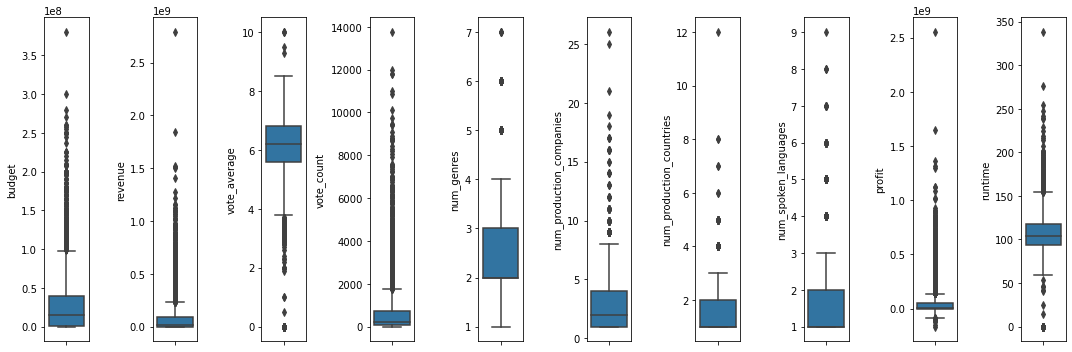

In [13]:
num_columns = len(X.columns)
fig, axes = plt.subplots(1, num_columns, figsize = (15, 5))
for i in range(num_columns):
    sns.boxplot(y = X.columns[i], data = X, orient = 'v', ax = axes[i])
plt.tight_layout()

**Data exploration of the predicted variable**

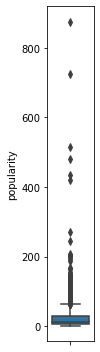

In [14]:
fig, axes = plt.subplots(1, 1, figsize = (1.5, 5))
sns.boxplot(y = Y['popularity'], data = Y, orient = 'v')
plt.tight_layout()

**Performing Regression on the datasets**

Model coefficient [15.80220667]
R_squared value:  0.22630617459143093
Adjusted R_squared value:  0.22610421848978424


[Text(0, 0.5, 'popularity'), Text(0.5, 0, 'budget'), Text(0.5, 1.0, 'Plot')]

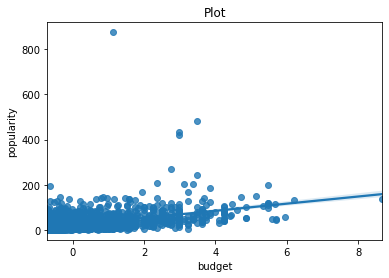

In [15]:
#Simple linear regression using 'budget' as predictor to predict popularity.

from sklearn import linear_model
import numpy

n = len(x_train) #Number of observations in the training set
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 0].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 0].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)
# Plot 
ax = sns.regplot(x_train_scaled[:, 0], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'budget', ylabel = 'popularity')

Model coefficient [20.27355683]
R_squared value:  0.3550460973010354
Adjusted R_squared value:  0.3548777459821373
10


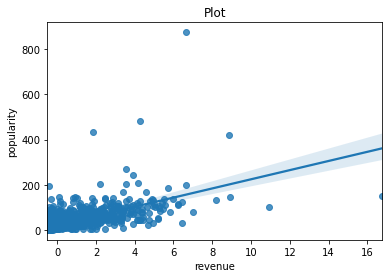

In [16]:
#Simple linear regression using 'revenue' as predictor to predict popularity.
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 1].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 1].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)
# Plot 
ax = sns.regplot(x_train_scaled[:, 1], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'revenue', ylabel = 'popularity')

print(len(X.columns))

Model coefficient [23.80864697]
R_squared value:  0.6300683998976688
Adjusted R_squared value:  0.6299718372247107


[Text(0, 0.5, ' popularity'),
 Text(0.5, 0, 'vote_count'),
 Text(0.5, 1.0, 'Plot')]

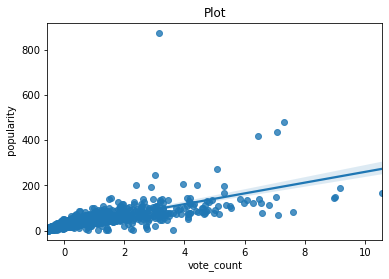

In [17]:
#Simple linear regression using 'vote_count' as predictor to predict popularity.
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 3].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 3].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)
# Plot 
ax = sns.regplot(x_train_scaled[:, 3], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'vote_count', ylabel = ' popularity')

Model coefficient [5.08273789]
R_squared value:  0.011735850028733206
Adjusted R_squared value:  0.011477884967398988


[Text(0, 0.5, 'popularity'),
 Text(0.5, 0, 'num_genres'),
 Text(0.5, 1.0, 'Plot')]

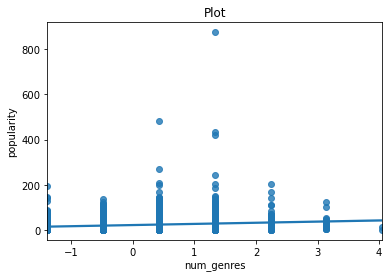

In [18]:
#Simple linear regression using 'num_genres' as predictor to predict popularity.
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 4].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 4].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

# Plot 
ax = sns.regplot(x_train_scaled[:, 4], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'num_genres', ylabel = 'popularity')


Model coefficient [5.58037696]
R_squared value:  0.02470487104907019
Adjusted R_squared value:  0.024450291271218227


[Text(0, 0.5, 'popularity'),
 Text(0.5, 0, 'num_production_companies'),
 Text(0.5, 1.0, 'Plot')]

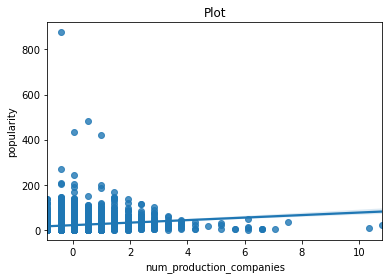

In [19]:
#Simple linear regression using 'num_production_companies' as predictor to predict popularity.
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 5].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 5].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

# Plot 
ax = sns.regplot(x_train_scaled[:, 5], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'num_production_companies', ylabel = 'popularity')

Model coefficient [1.64132386]
R_squared value:  0.0061964533838043045
Adjusted R_squared value:  0.005937042382338276


[Text(0, 0.5, 'popularity'),
 Text(0.5, 0, 'num_production_countries'),
 Text(0.5, 1.0, 'Plot')]

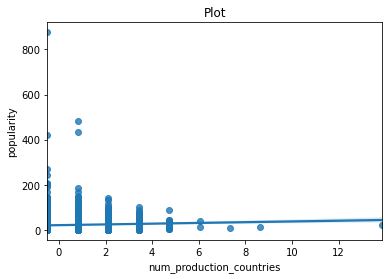

In [20]:
#Simple linear regression using 'num_production_countries' as predictor to predict popularity.
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 6].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 6].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

# Plot 
ax = sns.regplot(x_train_scaled[:, 6], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'num_production_countries', ylabel = 'popularity')

Model coefficient [2.08176019]
R_squared value:  0.0005629631593411366
Adjusted R_squared value:  0.0003020816566419171


[Text(0, 0.5, 'popularity'),
 Text(0.5, 0, 'num_spoken_languages'),
 Text(0.5, 1.0, 'Plot')]

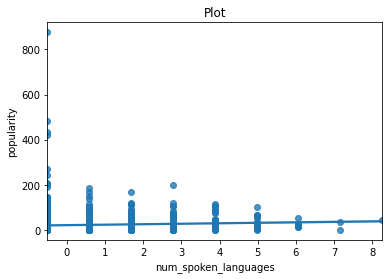

In [21]:
#Simple linear regression using 'num_spoken_languages' as predictor to predict popularity.
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 7].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 7].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

# Plot 
ax = sns.regplot(x_train_scaled[:, 7], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'num_spoken_languages', ylabel = 'popularity')

Model coefficient [7.0555049]
R_squared value:  0.04410121715497607
Adjusted R_squared value:  0.0438517003753246


[Text(0, 0.5, 'popularity'), Text(0.5, 0, 'runtime'), Text(0.5, 1.0, 'Plot')]

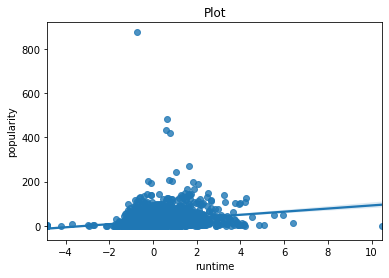

In [22]:
#Simple linear regression using 'runtime' as predictor to predict popularity.
p = 1 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, 9].reshape(-1, 1), y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, 9].reshape(-1, 1))
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

# Plot 
ax = sns.regplot(x_train_scaled[:, 9], y_train['popularity'])
ax.set(title = 'Plot', xlabel = 'runtime', ylabel = 'popularity')


In [23]:
#Multiple linear regression using all predictor to predict popularity.
p = len(x_train.columns) #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled, y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled)
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

Model coefficient [ 1.57008307  1.73541017  1.65110193 19.56095742  0.91619063  1.56916315
 -0.11768996 -0.81849668  1.60672731 -0.35812605]
R_squared value:  0.6123210704933378
Adjusted R_squared value:  0.6113067352513005


In [24]:
#Multiple linear regression using "budget", "num_production_companies", "runtime" as predictor to predict popularity.
p = 3 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, [0,5,9]], y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, [0,5,9]])
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

Model coefficient [14.60618505  2.36935714  2.66320166]
R_squared value:  0.23495926005789286
Adjusted R_squared value:  0.2343598549338849


In [25]:
#Multiple linear regression using "vote_count", "profit" as predictor to predict popularity.
p = 2 #number of predictor

model = linear_model.LinearRegression()
fitted_model = model.fit(X = x_train_scaled[:, [3,8]], y = y_train['popularity'])
predicted = fitted_model.predict(x_test_scaled[:, [3,8]])
corr_coef = numpy.corrcoef(predicted,y_test['popularity'])[1, 0]
R_squared = corr_coef ** 2
adj_R_squared = 1 - ((1 - R_squared)*(n - 1)/(n - p - 1))

print("Model coefficient",model.coef_)
print("R_squared value: ",R_squared)
print("Adjusted R_squared value: ",adj_R_squared)

Model coefficient [21.23768393  3.38028349]
R_squared value:  0.6188602511867185
Adjusted R_squared value:  0.6186612225972599


**The following are the conclusions we made from regression analysis:**

1.Among the all variables the "vote_count" alone predicts the popularity with highest accuracy as expected with Adjusted R_squared value: 0.629.

2.Among the all features know before release the "budget", "num_production_companies", "runtime" are the three variables that predicts the popularity with best Adjusted R_squared value: 0.234 which is still low but is best among these features to reflect the popularity.

3.Also we observed that the best performance/adjusted_R_squared value given by the multiple linear regression model with "vote_count", "profit" as predictor variables.As we increase the number of predictor variables in addition to these two the performance/adjusted_R_squared slightly decrease which can be explained by the overfitting of the model.

**Performing clustering on the datasets**

In [26]:
#creating a popular boolean where 0 = not popular, 1 = popular
# popular is assigned as 1 if the popularity is >= the mean popularity of all movies in the dataset
avg_popularity = movies['popularity'].mean()
movies['popular'] = [0 if x < avg_popularity else 1 for x in movies['popularity']] 
movies['popular'].astype(int)

0       1
1       1
2       1
3       1
4       1
       ..
4798    0
4799    0
4800    0
4801    0
4802    0
Name: popular, Length: 4792, dtype: int32

Supervised metric:  0.0004136723928973663
Unsupervised metric:  0.893891297709226


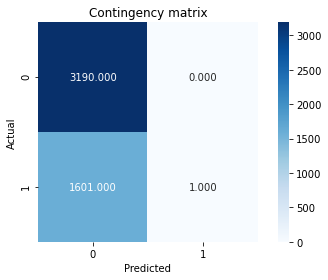

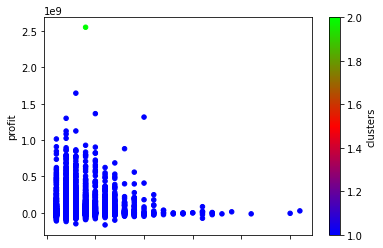

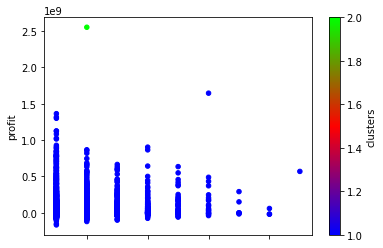

In [27]:

'''
Heirarchical clustering with single linkage using 'profit', 'num_production_companies', 'num_spoken_languages' variables
'''

x_c1 = X[['profit', 'num_production_companies', 'num_spoken_languages']]

scaler = StandardScaler()
scaler.fit(x_c1)
x_c1_scaled = scaler.transform(x_c1)



clustering = linkage(x_c1_scaled, method="single", metric="euclidean")
clusters = fcluster(clustering, 2, criterion='maxclust')

# print contingency matrix
cont_matrix = metrics.cluster.contingency_matrix(movies['popular'], clusters)
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

# print out unsupervised and supervised evaluation metrics 
adjusted_rand_index = metrics.adjusted_rand_score(movies['popular'], clusters)
silhouette_coefficient = metrics.silhouette_score(x_c1_scaled, clusters, metric = "euclidean")
print("Supervised metric: ", adjusted_rand_index)
print("Unsupervised metric: ", silhouette_coefficient)

movies['clusters'] = clusters
ax = movies.plot(kind = 'scatter', x = 'num_production_companies', y = 'profit',c = 'clusters', colormap = plt.cm.brg)
ax = movies.plot(kind = 'scatter', x = 'num_spoken_languages', y = 'profit', c = 'clusters', colormap = plt.cm.brg)



Supervised metric:  0.11848200720110373
Unsupervised metric:  0.5111279652907308


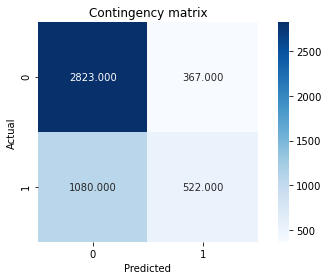

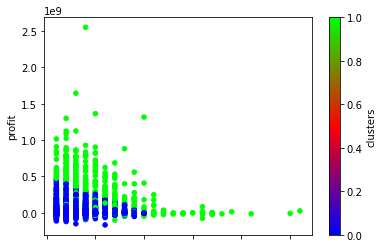

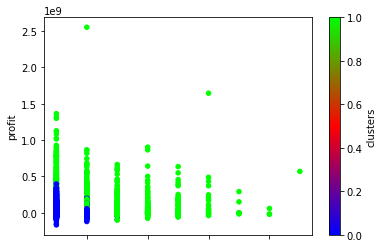

In [28]:

'''
K-means clustering with 2 clusters using 'profit', 'num_production_companies', 'num_spoken_languages' variables
'''


x_c1 = X[['profit', 'num_production_companies', 'num_spoken_languages']]

scaler = StandardScaler()
scaler.fit(x_c1)
x_c1_scaled = scaler.transform(x_c1)


clustering = KMeans(n_clusters = 2, init = 'random', n_init = 10, random_state = 0).fit(x_c1_scaled)
clusters = clustering.labels_


# print contingency matrix
cont_matrix = metrics.cluster.contingency_matrix(movies['popular'], clusters)
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

# print out unsupervised and supervised evaluation metrics 
adjusted_rand_index = metrics.adjusted_rand_score(movies['popular'], clusters)
silhouette_coefficient = metrics.silhouette_score(x_c1_scaled, clusters, metric = "euclidean")
print("Supervised metric: ", adjusted_rand_index)
print("Unsupervised metric: ", silhouette_coefficient)

movies['clusters'] = clusters
ax = movies.plot(kind = 'scatter', x = 'num_production_companies', y = 'profit',c = 'clusters', colormap = plt.cm.brg)
ax = movies.plot(kind = 'scatter', x = 'num_spoken_languages', y = 'profit', c = 'clusters', colormap = plt.cm.brg)

Supervised metric:  0.0004136723928973663
Unsupervised metric:  0.8870683761584796


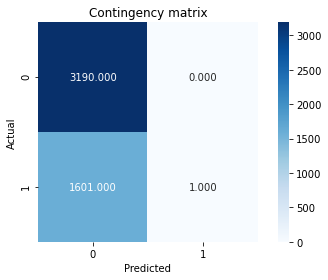

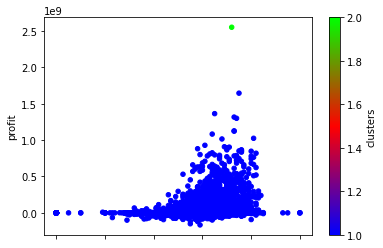

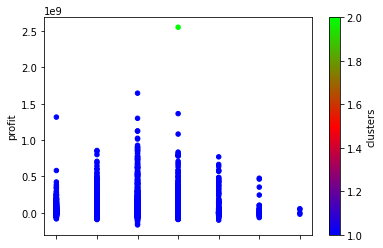

In [29]:

'''
Heirarchical clustering with single linkage using 'profit', 'vote_average', 'num_genres' variables
'''


x_c1 = X[['profit', 'vote_average', 'num_genres']]

scaler = StandardScaler()
scaler.fit(x_c1)
x_c1_scaled = scaler.transform(x_c1)



clustering = linkage(x_c1_scaled, method="single", metric="euclidean")
clusters = fcluster(clustering, 2, criterion='maxclust')

# print contingency matrix
cont_matrix = metrics.cluster.contingency_matrix(movies['popular'], clusters)
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

# print out unsupervised and supervised evaluation metrics 
adjusted_rand_index = metrics.adjusted_rand_score(movies['popular'], clusters)
silhouette_coefficient = metrics.silhouette_score(x_c1_scaled, clusters, metric = "euclidean")
print("Supervised metric: ", adjusted_rand_index)
print("Unsupervised metric: ", silhouette_coefficient)

movies['clusters'] = clusters
ax = movies.plot(kind = 'scatter', x = 'vote_average', y = 'profit',c = 'clusters', colormap = plt.cm.brg)
ax = movies.plot(kind = 'scatter', x = 'num_genres', y = 'profit', c = 'clusters', colormap = plt.cm.brg)

Supervised metric:  0.03054247127242796
Unsupervised metric:  0.3033855961940502


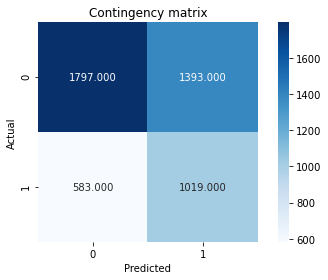

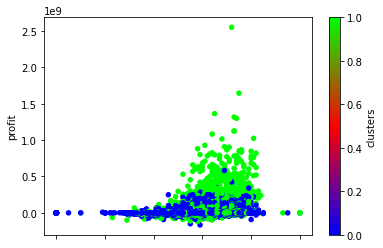

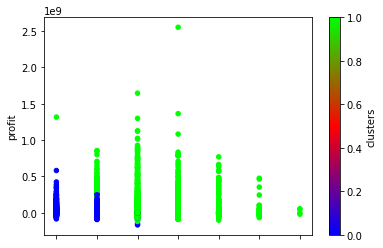

In [30]:
'''
K-means clustering with 2 clusters  using 'profit', 'vote_average', 'num_genres' variables
'''


x_c1 = X[['profit', 'vote_average', 'num_genres']]

scaler = StandardScaler()
scaler.fit(x_c1)
x_c1_scaled = scaler.transform(x_c1)


clustering = KMeans(n_clusters = 2, init = 'random', n_init = 10, random_state = 0).fit(x_c1_scaled)
clusters = clustering.labels_


# print contingency matrix
cont_matrix = metrics.cluster.contingency_matrix(movies['popular'], clusters)
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

# print out unsupervised and supervised evaluation metrics 
adjusted_rand_index = metrics.adjusted_rand_score(movies['popular'], clusters)
silhouette_coefficient = metrics.silhouette_score(x_c1_scaled, clusters, metric = "euclidean")
print("Supervised metric: ", adjusted_rand_index)
print("Unsupervised metric: ", silhouette_coefficient)


movies['clusters'] = clusters
ax = movies.plot(kind = 'scatter', x = 'vote_average', y = 'profit',c = 'clusters', colormap = plt.cm.brg)
ax = movies.plot(kind = 'scatter', x = 'num_genres', y = 'profit', c = 'clusters', colormap = plt.cm.brg)

Supervised metric:  0.0004136723928973663
Unsupervised metric:  0.910886709030747


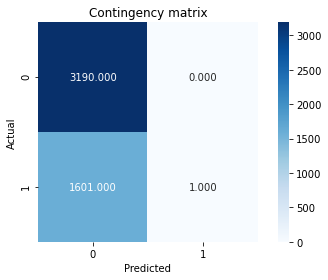

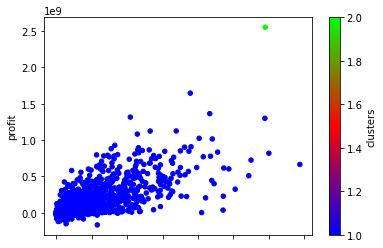

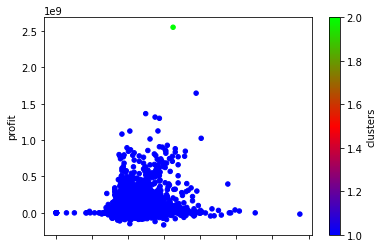

In [31]:
'''
Heirarchical clustering with single linkage using 'profit', 'vote_count', 'runtime' variables
'''

x_c1 = X[['profit', 'vote_count', 'runtime']]

scaler = StandardScaler()
scaler.fit(x_c1)
x_c1_scaled = scaler.transform(x_c1)


clustering = linkage(x_c1_scaled, method="single", metric="euclidean")
clusters = fcluster(clustering, 2, criterion='maxclust')

# print contingency matrix
cont_matrix = metrics.cluster.contingency_matrix(movies['popular'], clusters)
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

# print out unsupervised and supervised evaluation metrics 
adjusted_rand_index = metrics.adjusted_rand_score(movies['popular'], clusters)
silhouette_coefficient = metrics.silhouette_score(x_c1_scaled, clusters, metric = "euclidean")
print("Supervised metric: ", adjusted_rand_index)
print("Unsupervised metric: ", silhouette_coefficient)

movies['clusters'] = clusters
ax = movies.plot(kind = 'scatter', x = 'vote_count', y = 'profit',c = 'clusters', colormap = plt.cm.brg)
ax = movies.plot(kind = 'scatter', x = 'runtime', y = 'profit', c = 'clusters', colormap = plt.cm.brg)

Supervised metric:  0.14272222391796952
Unsupervised metric:  0.6875152043814955


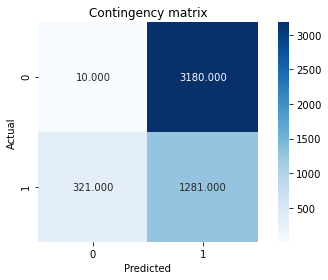

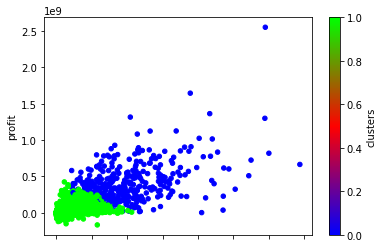

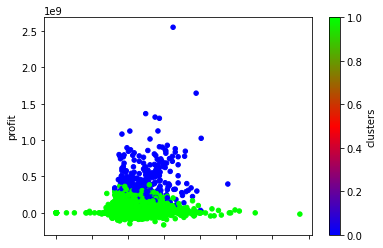

In [32]:
'''
K-means clustering with 2 clusters using 'profit', 'vote_count', 'runtime' variables
'''

x_c1 = X[['profit', 'vote_count', 'runtime']]

scaler = StandardScaler()
scaler.fit(x_c1)
x_c1_scaled = scaler.transform(x_c1)

clustering = KMeans(n_clusters = 2, init = 'random', n_init = 10, random_state = 0).fit(x_c1_scaled)
clusters = clustering.labels_


# print contingency matrix
cont_matrix = metrics.cluster.contingency_matrix(movies['popular'], clusters)
sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()

# print out unsupervised and supervised evaluation metrics 
adjusted_rand_index = metrics.adjusted_rand_score(movies['popular'], clusters)
silhouette_coefficient = metrics.silhouette_score(x_c1_scaled, clusters, metric = "euclidean")
print("Supervised metric: ", adjusted_rand_index)
print("Unsupervised metric: ", silhouette_coefficient)

movies['clusters'] = clusters
ax = movies.plot(kind = 'scatter', x = 'vote_count', y = 'profit',c = 'clusters', colormap = plt.cm.brg)
ax = movies.plot(kind = 'scatter', x = 'runtime', y = 'profit', c = 'clusters', colormap = plt.cm.brg)

**Following are the conclusions we made from clustering analysis:**
    
The best performing model was K-means clustering with two clusters and using variables 'profit', 'vote_count', 'runtime'. It had a supervised metric of .143 and unsupervised metric of .688. The supervised metric was the highest out of all of our clustering models. This can be explaining by the use of predictor 'vote_count' which would suggest more popular movies have more votes. 

In general the K-means clustering always outperformed the Hierarchical clustering with single linkage. For the models using Hierarchical clustering, the supervised metric was almost always 0, suggesting that the clusters were not very similar. 




*** FINAL CONCLUSION ***

Both data modeling techniques of linear regression and clustering support that the best predictors for a movie's popularity are the number of ratings it received (vote_count) and the total profit generated (profit). 
